[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.axes_style("whitegrid")

from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler, binarize
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score  
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_validate

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

# Const And Global Vars

In [2]:
CORES = 3
model_dict = {}

# Declare funcs

In [13]:
def paint():
    tmp = train_df.groupby('label').sum()
    train_data = np.array(tmp, dtype='float32')

    first_image = train_data[0]

    first_image = np.array(first_image, dtype='uint8')
    pixels = first_image.reshape((28, 28))
    import numpy as np; np.random.seed(0)

    import seaborn as sns; sns.set()

    # uniform_data = np.random.rand(10, 12)
    uniform_data = pixels#//500
    ax = sns.heatmap(uniform_data)

    uniform_data.max()

In [15]:
def evaluate(true, pred):
#     model_accuracy = roc_auc_score(true, pred, multi_class="ovr")
#     null_accuracy = roc_auc_score(true, true.replace(1, 0))
    
#     print("Null AUC Score: {:.5f}".format(null_accuracy))
#     print("Model AUC Score: {:.5f}".format(model_accuracy))

#     if null_accuracy >= model_accuracy:
#         print("The model isn't effective")
# #         return
#     else:
#         print("The model is better then a 'dumb' model")
    print("confusion_matrix:\n", confusion_matrix(true, pred))
    print(classification_report(true, pred))

In [40]:
def score_models(model, model_scores):
    model_dict.update({model: model_scores})

    print("Accuracy: {:.2f} (+/- {:.2f})".format(model_scores['test_score'].mean(), model_scores['test_score'].std() * 2))
    print('Train time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['fit_time'].mean(), model_scores['fit_time'].std() * 2, model_scores['fit_time'].sum()))
    print('Test time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['score_time'].mean(), model_scores['score_time'].std() * 2, model_scores['score_time'].sum()))

In [70]:
def find_best_model():
    max_score = 0
    best_key = None
    for key in model_dict:
        model_score=model_dict[key]['test_score'].mean()
#         model_score = model_dict[key].mean()
#         try:   
#             model_score=model_dict[key]['test_score'].mean()
#         except IndexError: # remove this
#             model_score=model_dict[key].mean()
        if max_score < model_score:
            max_score = model_score
            best_key = key
    best_model_name = best_key
    print('the best model is {}'.format(best_key).split('(')[0], end = ' ')
    print('with the score of {}'.format(max_score))
    return best_key, max_score

---
# Data preparation

## load data

In [3]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

In [4]:
train_df.head()
train_df.isnull().sum().unique()

array([0], dtype=int64)

0 is t shirt\
1 is trousers\
2 is pullover\
3 is dress\
4 is coat\
5 is sandals\
6 is shirt\
7 is sneaker\
8 is bag\
9 is ankle boots

In [5]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [6]:
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


## split the training data into train and validate

In [7]:
train_data = np.array(train_df, dtype='float32')
test_data = np.array(test_df, dtype='float32')

X_train = train_data[:, 1:] / 1
y_train = train_data[:, 0]

X_test = test_data[:, 1:] / 1#/128#/255
y_test = test_data[:, 0]

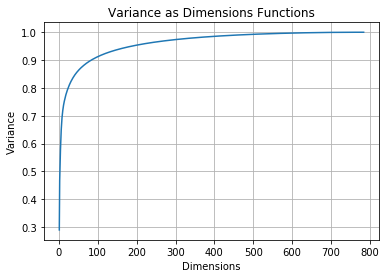

In [8]:
pca = PCA(random_state=0)
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, len(cumsum)+1)
plt.plot(x, cumsum)
plt.grid(True)
plt.title('Variance as Dimensions Functions')
plt.xlabel('Dimensions')
plt.ylabel('Variance')
plt.show()

In [10]:
pca = PCA(random_state=0, n_components=0.90)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
d = len(pca.singular_values_)
print('the number of vectors after pca is {}'.format(d))

the number of vectors after pca is 84


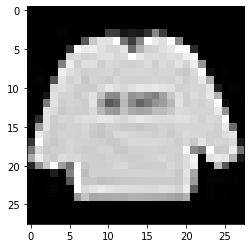

In [12]:
first_image = X_train[0]

first_image = np.array(first_image, dtype='uint8')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

---
# Models

## Run The Models

### Naive Bayes

In [20]:
gnb = GaussianNB()

# gnb.fit(X_train_pca, y_train)
# predictions = gnb.predict(X_test_pca)
# evaluate(y_test, predictions)

gnb_scores = cross_validate(gnb, X_train_pca, y_train, cv=10)

score_models('GaussianNB', gnb_scores)

Accuracy: 0.77 (+/- 0.01)
Train time: 0.07 seconds (+/- 0.02) for a total of 0.74 seconds
Test time: 0.08 seconds (+/- 0.02) for a total of 0.82 seconds


In [21]:
# mnb = MultinomialNB()
# mnb.fit(X_train_pca, y_train)
# predictions = mnb.predict(X_test_pca)
# evaluate(y_test, predictions)

### Random Forest

In [42]:
rf = RandomForestClassifier(random_state=0, max_depth=None, n_estimators=100, n_jobs=CORES)

# scores = cross_val_score(rf, X_train_pca, y_train, cv=10, scoring='neg_mean_squared_error')
# rf_score = np.sqrt(-scores)
rf_scores = cross_validate(rf, X_train_pca, y_train, cv=10, n_jobs=CORES)

# model_dict.update({"RandomForestClassifier": rf_score})

# print("Accuracy: %0.2f (+/- %0.2f)" % (rf_score.mean(), rf_score.std() * 2))

score_models(rf, rf_scores)

# tmp = cross_val_predict(rf, X_train_pca, y_train, cv=10, n_jobs=CORES)


# # print(len(predictions))
# # print(len(tmp))
# # y_test_appended = np.append(np.append(y_test,y_test),np.append(np.append(y_test, y_test),np.append(y_test, y_test)))
# evaluate(y_train, tmp)

Accuracy: 0.87 (+/- 0.01)
Train time: 32.66 seconds (+/- 4.13) for a total of 326.64 seconds
Test time: 0.13 seconds (+/- 0.09) for a total of 1.35 seconds


### KNN

In [26]:
#now lets find the optimum K 
k_max = 15
k_min = 1
err_rate = []
for i in range(k_min, k_max+1):
    k = KNeighborsClassifier(n_neighbors=i, n_jobs=CORES)
#     k.fit(X_train_pca, y_train)
#     pred_i = k.predict(X_test_pca)
#     err_rate.append(np.mean(pred_i != y_test))
    scores = cross_validate(k, X_train_pca, y_train, cv=10, n_jobs=CORES)['test_score']
    if scores.std() > 0.5:
        err_rate.append(0)
    else:
        err_rate.append(scores.mean())

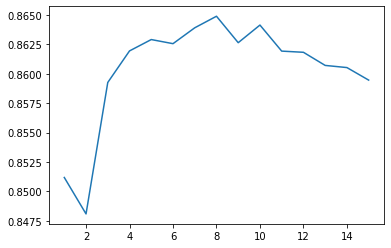

In [27]:
plt.plot(np.arange(k_min, k_max+1), err_rate)
plt.show()

In [28]:
index = err_rate.index(max(err_rate)) + 1
index

8

In [29]:
k = KNeighborsClassifier(n_neighbors=index, n_jobs=CORES)
# k.fit(X_train_pca, y_train)
# predictions = k.predict(X_test_pca)

In [30]:
k_scores = cross_validate(k, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(k, k_scores)

Accuracy: 0.86 (+/- 0.01)
Train time: 2.22 seconds (+/- 1.07) for a total of 22.16 seconds
Test time: 22.37 seconds (+/- 11.01) for a total of 223.71 seconds


### Logistic Regression

In [43]:
lr = LogisticRegression(random_state=0, n_jobs=CORES)#, solver='lbfgs', penalty='l2')

lr_scores = cross_validate(lr, X_train_pca, y_train, cv=10, n_jobs=CORES)

# model_dict.update({"logistic regression": lr_scores})

# print("Accuracy: %0.2f (+/- %0.2f)" % (lr_scores['test_score'].mean(), lr_scores['test_score'].std() * 2))
# print('the mean train time is {} seconds'.format(lr_scores['fit_time'].mean()))
# print('the mean test time is {} seconds'.format(lr_scores['score_time'].mean()))

score_models(lr, lr_scores)

Accuracy: 0.84 (+/- 0.01)
Train time: 15.91 seconds (+/- 4.60) for a total of 159.10 seconds
Test time: 0.01 seconds (+/- 0.00) for a total of 0.09 seconds


### SVM

#### SVC

In [32]:
svc = SVC(random_state=0, max_iter=500)

svc_scores = cross_validate(svc, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(svc, svc_scores)

Accuracy: 0.79 (+/- 0.02)
Train time: 109.73 seconds (+/- 30.36) for a total of 1097.26 seconds
Test time: 16.20 seconds (+/- 5.55) for a total of 162.00 seconds


### Decision Tree

In [33]:
dtc = DecisionTreeClassifier(random_state=0)
dtc_scores = cross_validate(dtc, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(dtc, dtc_scores)

Accuracy: 0.77 (+/- 0.01)
Train time: 13.18 seconds (+/- 0.57) for a total of 131.79 seconds
Test time: 0.00 seconds (+/- 0.00) for a total of 0.03 seconds


### Gradient Boosting

In [34]:
gb = GradientBoostingClassifier(random_state=0)
gb_scores = cross_validate(gb, X_train_pca, y_train, cv=10, n_jobs=CORES)
score_models(gb, gb_scores)

Accuracy: 0.85 (+/- 0.01)
Train time: 2267.20 seconds (+/- 169.22) for a total of 22671.98 seconds
Test time: 0.11 seconds (+/- 0.01) for a total of 1.08 seconds


## Find Best Model

In [71]:
best_model, best_model_score = find_best_model()

the best model is RandomForestClassifier with the score of 0.8675


## Improve The Model

### Ada Boost

In [72]:
base_estimetor = best_model
adb = AdaBoostClassifier(base_estimetor, random_state=0)
adb_scores = cross_validate(adb, X_train_pca, y_train, cv=10, n_jobs=CORES)

#### check if the model was improved

In [75]:
if adb_scores['test_score'].mean() > best_model_score:
    best_model = adb

## Test The Model On The Test Data

In [77]:
best_model.fit(X_train_pca, y_train)
predictions = best_model.predict(X_test_pca)
evaluate(y_test, predictions)

confusion_matrix:
 [[857   0  19  36   3   3  70   0  12   0]
 [  4 963   8  19   2   0   4   0   0   0]
 [ 12   0 802   7 105   1  61   0  12   0]
 [ 26   6  11 909  24   1  19   0   4   0]
 [  1   1  66  26 850   0  50   0   6   0]
 [  1   0   0   1   0 917   0  52   5  24]
 [178   2 104  26  83   1 591   0  15   0]
 [  0   0   0   0   0  39   0 903   0  58]
 [  2   0   6   4   3  10   5   4 965   1]
 [  0   0   0   0   0  16   0  39   0 945]]
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82      1000
         1.0       0.99      0.96      0.98      1000
         2.0       0.79      0.80      0.80      1000
         3.0       0.88      0.91      0.90      1000
         4.0       0.79      0.85      0.82      1000
         5.0       0.93      0.92      0.92      1000
         6.0       0.74      0.59      0.66      1000
         7.0       0.90      0.90      0.90      1000
         8.0       0.95      0.96      0.96      1000
         

### run without pca

In [36]:
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
evaluate(y_test, predictions)

confusion_matrix:
 [[862   0  10  29   2   1  83   0  13   0]
 [  2 975   5  14   1   1   2   0   0   0]
 [  9   1 802  12 115   0  51   0  10   0]
 [ 22   6  11 925  21   0  15   0   0   0]
 [  1   0  58  24 869   0  45   0   3   0]
 [  0   0   0   0   0 946   0  40   3  11]
 [163   1 106  27  75   0 614   0  14   0]
 [  0   0   0   0   0  18   0 931   1  50]
 [  2   1   8   0   2   2   8   2 975   0]
 [  0   0   1   0   0   6   0  41   3 949]]
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.84      1000
         1.0       0.99      0.97      0.98      1000
         2.0       0.80      0.80      0.80      1000
         3.0       0.90      0.93      0.91      1000
         4.0       0.80      0.87      0.83      1000
         5.0       0.97      0.95      0.96      1000
         6.0       0.75      0.61      0.68      1000
         7.0       0.92      0.93      0.92      1000
         8.0       0.95      0.97      0.96      1000
         